/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0
No. of rows in Training Features:  404
No. of rows in Test Features:  102
No. of columns in Training Features:  13
No. of columns in Test Features:  13
No. of rows in Training Label:  404
No. of rows in Test Label:  102
No. of columns in Training Label:  1
No. of columns in Test Label:  1
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp4eegvmvj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({})

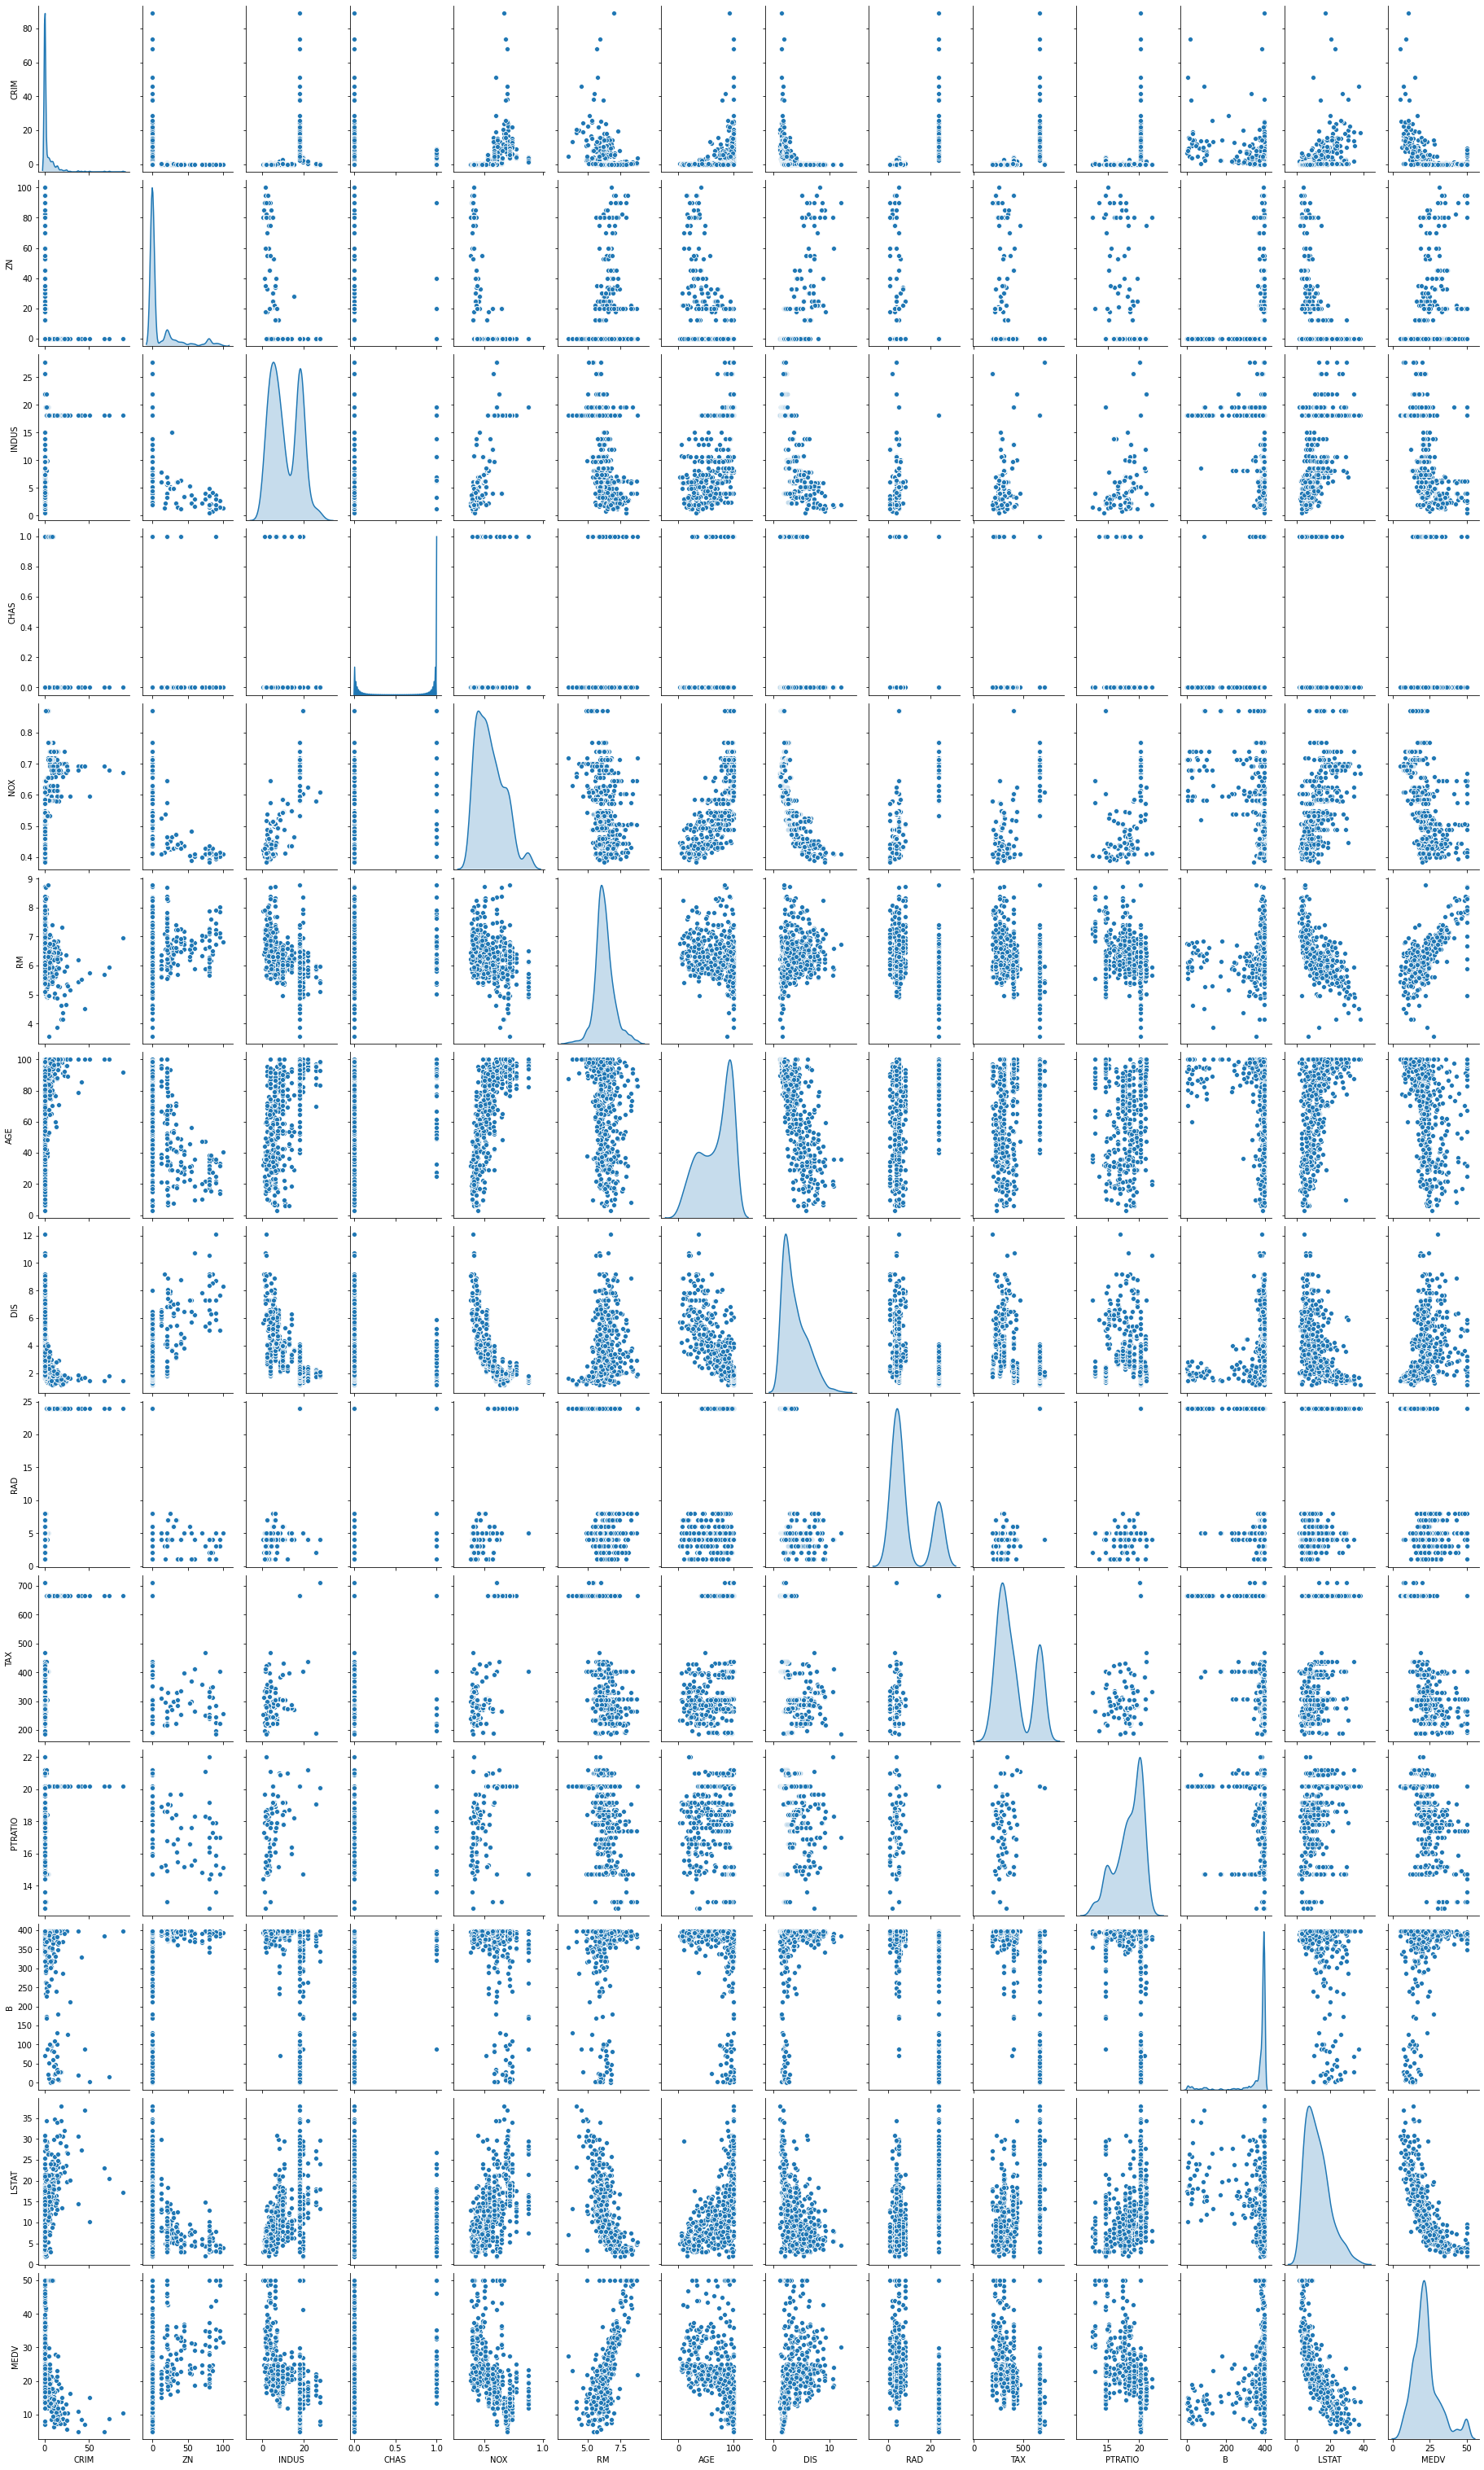

In [1]:


"""## Import the required Modules"""

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.estimator import LinearRegressor
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

print(tf.__version__)

"""## Load and configure the Boston Housing Dataset"""

boston_load = datasets.load_boston()

feature_columns = boston_load.feature_names
target_column = boston_load.target

boston_data = pd.DataFrame(boston_load.data, columns=feature_columns).astype(np.float32)
boston_data['MEDV'] = target_column.astype(np.float32)

boston_data.head()

"""## Checking the relation between the variables using Pairplot and Correlation Graph"""

sb.pairplot(boston_data, diag_kind="kde", height=3, aspect=0.6)

correlation_data = boston_data.corr()
correlation_data.style.background_gradient(cmap='coolwarm', axis=None)

"""## Descriptive Statistics - Central Tendency and Dispersion"""

stats = boston_data.describe()
boston_stats = stats.transpose()
boston_stats

"""## Select the required columns"""

X_data = boston_data[[i for i in boston_data.columns if i not in ['MEDV']]]
Y_data = boston_data[['MEDV']]

"""## Train Test Split"""

training_features , test_features ,training_labels, test_labels = train_test_split(X_data , Y_data , test_size=0.2)

print('No. of rows in Training Features: ', training_features.shape[0])
print('No. of rows in Test Features: ', test_features.shape[0])
print('No. of columns in Training Features: ', training_features.shape[1])
print('No. of columns in Test Features: ', test_features.shape[1])

print('No. of rows in Training Label: ', training_labels.shape[0])
print('No. of rows in Test Label: ', test_labels.shape[0])
print('No. of columns in Training Label: ', training_labels.shape[1])
print('No. of columns in Test Label: ', test_labels.shape[1])

stats = training_features.describe()
stats = stats.transpose()
stats

stats = test_features.describe()
stats = stats.transpose()
stats

"""## Normalize Data"""

def norm(x):
  stats = x.describe()
  stats = stats.transpose()
  return (x - stats['mean']) / stats['std']

normed_train_features = norm(training_features)
normed_test_features = norm(test_features)

"""## Build the Input Pipeline for TensorFlow model"""

def feed_input(features_dataframe, target_dataframe, num_of_epochs=10, shuffle=True, batch_size=32):
  def input_feed_function():
    dataset = tf.data.Dataset.from_tensor_slices((dict(features_dataframe), target_dataframe))
    if shuffle:
      dataset = dataset.shuffle(2000)
    dataset = dataset.batch(batch_size).repeat(num_of_epochs)
    return dataset
  return input_feed_function

train_feed_input = feed_input(normed_train_features, training_labels)
train_feed_input_testing = feed_input(normed_train_features, training_labels, num_of_epochs=1, shuffle=False)
test_feed_input = feed_input(normed_test_features, test_labels, num_of_epochs=1, shuffle=False)

"""## Model Training"""

feature_columns_numeric = [tf.feature_column.numeric_column(m) for m in training_features.columns]

linear_model = LinearRegressor(feature_columns=feature_columns_numeric, optimizer='RMSProp')

linear_model.train(train_feed_input)

"""## Predictions"""

train_predictions = linear_model.predict(train_feed_input_testing)
test_predictions = linear_model.predict(test_feed_input)

train_predictions_series = pd.Series([p['predictions'][0] for p in train_predictions])
test_predictions_series = pd.Series([p['predictions'][0] for p in test_predictions])

train_predictions_df = pd.DataFrame(train_predictions_series, columns=['predictions'])
test_predictions_df = pd.DataFrame(test_predictions_series, columns=['predictions'])

training_labels.reset_index(drop=True, inplace=True)
train_predictions_df.reset_index(drop=True, inplace=True)

test_labels.reset_index(drop=True, inplace=True)
test_predictions_df.reset_index(drop=True, inplace=True)

train_labels_with_predictions_df = pd.concat([training_labels, train_predictions_df], axis=1)
test_labels_with_predictions_df = pd.concat([test_labels, test_predictions_df], axis=1)

"""## Validation"""

def calculate_errors_and_r2(y_true, y_pred):
  mean_squared_err = (mean_squared_error(y_true, y_pred))
  root_mean_squared_err = np.sqrt(mean_squared_err)
  r2 = round(r2_score(y_true, y_pred)*100,0)
  return mean_squared_err, root_mean_squared_err, r2

train_mean_squared_error, train_root_mean_squared_error, train_r2_score_percentage = calculate_errors_and_r2(training_labels, train_predictions_series)
test_mean_squared_error, test_root_mean_squared_error, test_r2_score_percentage = calculate_errors_and_r2(test_labels, test_predictions_series)

print('Training Data Mean Squared Error = ', train_mean_squared_error)
print('Training Data Root Mean Squared Error = ', train_root_mean_squared_error)
print('Training Data R2 = ', train_r2_score_percentage)

print('Test Data Mean Squared Error = ', test_mean_squared_error)
print('Test Data Root Mean Squared Error = ', test_root_mean_squared_error)
print('Test Data R2 = ', test_r2_score_percentage)